# 샘플링

난수는 확률 변수의 한 형태인데, 컴퓨터는 숫자를 다루는 것을 아주 잘하기 때문에 코드를 제외한 거의 모든 것은 결국 숫자로 바뀝니다. 난수를 만드는데 필요한 기본 도구 중에 하나는 어떤 분포에서 샘플을 추출하는 것입니다. 그럼 난수 생성기를 사용했을 때 어떤 일이 벌어지는지 보겠습니다. 우선 필요한 모듈을 import 하겠습니다.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import nd
import numpy as np

In [2]:
import random
for i in range(10):
    print(random.random())

0.278231300399582
0.23475908293279435
0.12245613762528162
0.8910285078261634
0.9206118509513801
0.20734665603852465
0.19081536824851153
0.7237816911568361
0.35514553468436716
0.29380111137819787


## 균등 분포(uniform distribution)

위 결과의 숫자들은 굉장히 임의로 선택된 것들입니다. 이 숫자들은 0과 1사이의 범위에서 잘 분포되어 있습니다. 즉, 어떤 특정 구간에 숫자들이 몰려있지 않습니다. (사실 *진짜* 난수 발생기가 아니기 때문에 그럴수도 있습니다.) 어떤 숫자가 $[0.2,0.3)$ 구간에서 선택될 가능성과 $[.593264, .693264)$ 구간에서 선택될 가능성이 비슷하다는 의미입니다. 이 난수 발생기는 내부적으로 임의의 정수를 먼저 만들고, 그 다음에 이 숫자를 최대 구간의 숫자로 나누는 방식으로 동작합니다. 정수를 얻고 싶은 경우에는, 다음과 같이하면 됩니다. 아래 코드는 0과 100사이의 임의의 정수를 생성합니다.

In [3]:
for i in range(10):
    print(random.randint(1, 100))

93
38
89
78
82
72
56
76
23
57


`randint` 가 정말로 균일하다는 것을 확인을 어떻게 할 수 있을까요? 직관적으로 가장 좋은 방법은 100만개의 난수를 생성해서 각 숫자가 몇 번 나오는지 계산하고, 이 분포가 균일한지를 확인하는 것입니다.

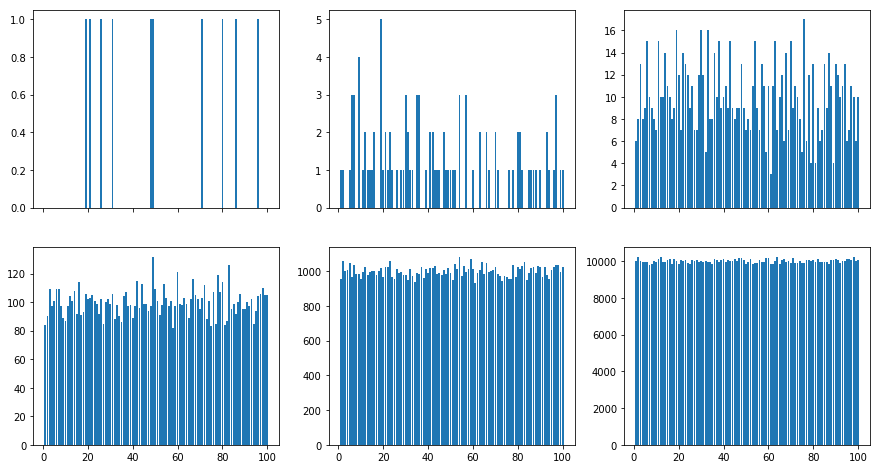

In [4]:
import math

counts = np.zeros(100)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.reshape(6)
# Mangle subplots such that we can index them in a linear fashion rather than
# a 2d grid

for i in range(1, 1000001):
    counts[random.randint(0, 99)] += 1
    if i in [10, 100, 1000, 10000, 100000, 1000000]:
        axes[int(math.log10(i))-1].bar(np.arange(1, 101), counts)
plt.show()

위 결과로 나온 그림으로 확인하면, 초기의 숫자는 *균등해 보이지 않습니다.* 100개의 정수에 대한 분포에서 100개보다 적은 개수를 뽑는 경우는 당연한 결과입니다. 하지만, 1000 샘플을 뽑아도 여전히 상당한 변동이 있습니다. 우리가 원하는 결과는 숫자를 뽑았을 때의 확률이  $p(x)$ 가 되는 것입니다.

## 카테고리 분포(categorical distribution)

사실, 100개 중에서 균일한 분포로 뽑기를 하는 것은 아주 간단합니다. 만약에 불균일한 확률을 사용해야한다면 어떻게 해야할까요? 동전을 던졌을 때 앞면이 나올 확률이 0.35이고 뒷면이 나올 확률이 0.65가 나오는 편향된 (biased) 동전을 간단한 예로 들어보겠습니다. 이를 구현하는 간단한 방법은  $[0,1]$ 구간에서 균일하게 숫자를 선택하고 그 수가 0.35 보다 작으면 앞면으로, 크면 뒷면으로 하는 것입니다. 그럼 코드를 보겠습니다.

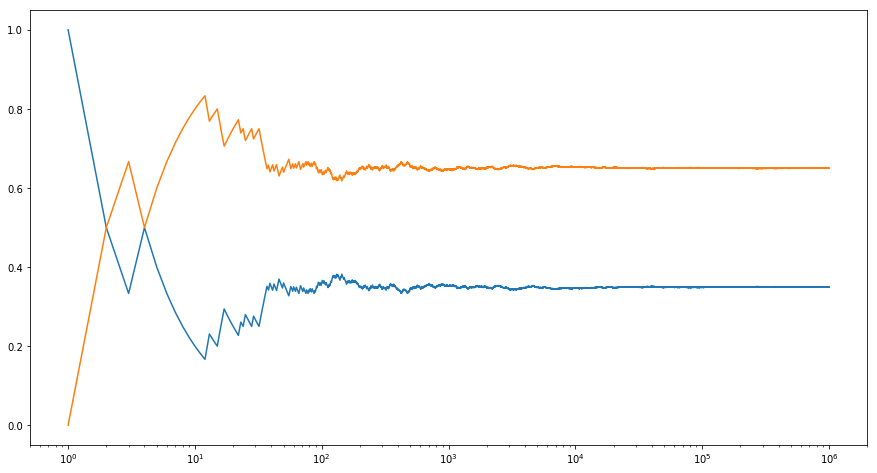

In [5]:
# Number of samples
n = 1000000
y = np.random.uniform(0, 1, n)
x = np.arange(1, n+1)
# Count number of occurrences and divide by the number of total draws
p0 = np.cumsum(y < 0.35) / x
p1 = np.cumsum(y >= 0.35) / x

plt.figure(figsize=(15, 8))
plt.semilogx(x, p0)
plt.semilogx(x, p1)
plt.show()

결과에서 보이듯이, 평균적으로 보면 35%가 0이고, 65%가 1입니다. 두 개 이상의 결과가 있다면 어떻게 할까요? 위 아이디어를 다음과 같이 일반화하면 됩니다. 예를 들면 $p = [0.1, 0.2, 0.05, 0.3, 0.25, 0.1]$ 와 같은 분포가 있다고 하면, 누적된 분포를 계산해서 $F = [0.1, 0.3, 0.35, 0.65, 0.9, 1]$ 를 얻습니다. (이는 Python의 `cumsum` 함수를 이용하면 간단히 할 수 있습니다.) 이전과 동일하게 $U[0,1]$ 범위의 균일 분포에서 난수 $x$ 를 뽑고,  $F[i-1] \leq x < F[i]$ 를 만족시키는 구간을 찾아서  $i$ 를 샘플 결과로 리턴합니다. 이렇게 하면 난수가 $[F[i-1], F[i])$ 구간에 속할 확률이 $p(i)$가 됩니다.

위 방법보다 훨씬 더 효율적인 알고리즘이 많이 있습니다. 예를 들면,  $n$ 개의 랜덤 변수에 대해서 $F$ 에 대한 이진 검색을 수행하면  $O(\log n)$ 시간이 걸립니다.  $O(n)​$ 만큼의 전처리를 하면 샘플링에 상수의 시간이 걸리는 [Alias Method](https://en.wikipedia.org/wiki/Alias_method) 와 같은 더 좋은 알고리즘들이 있습니다.

## 표준 분포(normal distribution)

표준 분포 (또는 가우시안 분포)는 $p(x) = \frac{1}{\sqrt{2 \pi}} \exp\left(-\frac{1}{2} x^2\right)$ 로 정의됩니다. 그림으로 확인해보겠습니다.

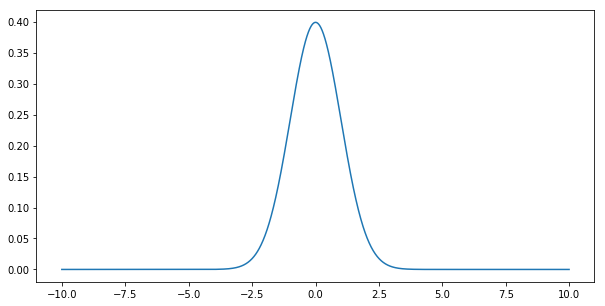

In [6]:
x = np.arange(-10, 10, 0.01)
p = (1/math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)
plt.figure(figsize=(10, 5))
plt.plot(x, p)
plt.show()

이 분포에서 샘플링을 하는 것은 그리 간단하지 않습니다. 우선 서포트가 무한합니다. 즉, 어떤  $x$ 값이 주어지든지 확률 밀도 $p(x)$ 값이 양수입니다. 두번째 특징은 확률 밀도는 균일하지 않습니다. 이 분포에서 샘플링을 수행하는 많은 기법이 있는데, 모든 알고리즘에 사용되는 주요 아이디어는  $p(x)$ 를 계층화해서 균일한 분포 $U[0,1]$ 로 매핑시키는 것입니다. 확률 적분 변환이 그 방법 중에 하나입니다.

$p$ 의 누적 분포 함수(cumulative distribution function, CDF)를 $F(x) = \int_{-\infty}^x p(z) dz$ 로 표기합니다. 이 방법은 앞에서 누적합의 연속된 버전이라고 할 수 있습니다. 이전과 같은 방법으로 균일하게 뽑은 $\xi$ 에 대해서 역으로 매핑하는 $F^{-1}(\xi)$ 를 정의할 수 있습니다. 벡터 $F$ 에 대한 정확한 구간을 찾는 이전의 문제와 다르게, 우리는 $F(x)$ 의 역을 구해야 합니다.

실제로 가우시안의 경우 CDF의 역을 구하는 것은 다소 까다롭습니다. 두 개의 균등한 분포들을 다뤄야하지만 *이차원* 적분이 더 다루기 쉽기 때문에 두 개의 표준 확률 변수로 만듭니다. 지금은 이 문제를 해결해주는 알고리즘이 있다고 해두겠습니다.

표준 분포는 또 다른 중요한 특징이 있습니다. 만약 어떤 분포에서 충분히 많은 뽑기를 해서 평균을 구한다면, 모든 분포는 표준 분포에 수렴합니다. 이를 더 자세히 이해하기 위해서, 세가지 중요한 개념들인 기대값(expected value), 평균, 그리고 분산을 소개하겠습니다. 

* 분포 $p$ 를 따르는 함수 $f$ 에 대한 기대값 $\mathbf{E}_{x \sim p(x)}[f(x)]$  은 적분 $\int_x p(x) f(x) dx$ 으로 계산됩니다. 즉, 이는 $p$ 에 따라 주어지는 모든 결과에 대한 평균값입니다.
* 함수 $f(x) = x$ 에 대한 기대값은 굉장히 중요합니다. 이 함수의 기대값은 $\mu := \mathbf{E}_{x \sim p(x)}[x]$ 입니다. 이는 전형적인 $x$ 에 대한 아이디어를 제공해주기 때문입니다. 
* 중요한 다른 개념으로는 분산이 있습니다. 이는 $\sigma^2 := \mathbf{E}_{x \sim p(x)}[(x-\mu)^2]$  으로 표현되며, 평균으로부터 얼마나 떨어져 있는지를 알려줍니다. 간단한 계산을 하면 분산은 $\sigma^2 = \mathbf{E}_{x \sim p(x)}[x^2] - \mathbf{E}^2_{x \sim p(x)}[x]$ 로 표현되기도 합니다.

위 개념은 확률 변수의 평균과 분산을 바꿀 수 있게 해줍니다. 예를 들면 확률 변수 $x$ 의 평균이 $\mu$ 일 경우 확률 변수 $x + c$ 의 평균은  $\mu + c$ 이 됩니다. 또한, 확률 변수가 $\gamma x$ 일 경우에는 분산은 $\gamma^2 \sigma^2$ 이 됩니다. 평균 $\mu$ 이고 분산이  $\sigma^2$ 인 확률 변수에 표준 분포(normal distribution)를 적용하면 $p(x) = \frac{1}{\sqrt{2 \sigma^2 \pi}} \exp\left(-\frac{1}{2 \sigma^2} (x-\mu)^2\right)$ 의 형태가 됩니다. 스캐일 팩터 $\frac{1}{\sigma}$ 가 적용된 것에 주의하세요. 이렇게 한 이유는 이 분포를 $\sigma$ 만큼 늘릴 경우, 같은 확률 값을 갖게 하기 위해서  $\frac{1}{\sigma}$ 만큼 줄여야 할 필요가 있기 때문입니다. (왜냐하면 분포의 가중치들의 합은 항상 1이어야하기 때문입니다.)

자 이제 통계학에서 가장 기본적인 이론 중에 하나에 대해서 알아볼 준비가 되었습니다. 이는 [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) 입니다. 이 이론은 충분히 잘 행동하는 확률 변수에 대해서, 특히 잘 정의된 평균과 분산을 가지고 있는 확률 변수, 전체 합은 표준 분포로 근접합니다. 이해를 돕기 위해서 시작할 때 사용했던 실험을 정수값 \{0, 1, 2\} 을 갖는 확률 변수를 사용해봅니다.

mean 0.9, variance 0.49


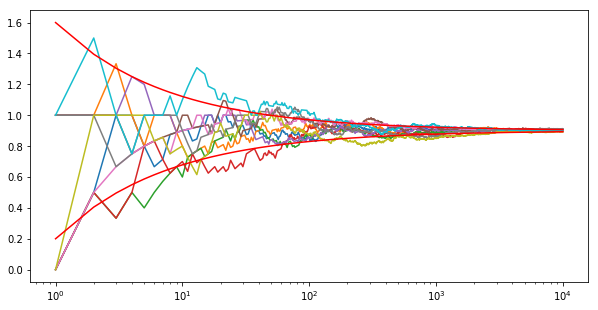

In [7]:
# Generate 10 random sequences of 10,000 uniformly distributed random variables
tmp = np.random.uniform(size=(10000,10))
x = 1.0 * (tmp > 0.3) + 1.0 * (tmp > 0.8)
mean = 1 * 0.5 + 2 * 0.2
variance = 1 * 0.5 + 4 * 0.2 - mean**2
print('mean {}, variance {}'.format(mean, variance))

# Cumulative sum and normalization
y = np.arange(1,10001).reshape(10000,1)
z = np.cumsum(x,axis=0) / y

plt.figure(figsize=(10,5))
for i in range(10):
    plt.semilogx(y,z[:,i])

plt.semilogx(y,(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.semilogx(y,-(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.show()

위 결과를 보면 많은 변수들의 평균만을 보면 처음 예제와 아주 비슷하게 보입니다. 즉, 이론이 맞다는 것을 보여줍니다. 확률 변수의 평균과 분산은 다음과 같이 표현됩니다.

$$\mu[p] := \mathbf{E}_{x \sim p(x)}[x] \text{ 와 } \sigma^2[p] := \mathbf{E}_{x \sim p(x)}[(x - \mu[p])^2]$$

그러면, $\lim_{n\to \infty} \frac{1}{\sqrt{n}} \sum_{i=1}^n \frac{x_i - \mu}{\sigma} \to \mathcal{N}(0, 1)$ 이 됩니다. 즉, 어떤 값으로부터 시작했는지 상관없이, 가우시안 분포에 항상 수렴하게 됩니다. 이것이 통계에서 가우시안 분포가 유명한 이유들 중에 하나입니다.

## 여러 분포들

그 외에도 유용한 분산들이 많이 있습니다. 더 자세한 내용은 통계책이나 위키피디아를 참조하세요.

* **이항 분포(Binomial Distribution)** 같은 분포에서 여러번 뽑을 때의 분포를 설명하는데 사용됩니다. 즉, 편향된 동전(동전 앞면이 나올 확률이 $\pi \in [0, 1]$ 인 동전을 사용할 때)을 10번 던져서 앞면이 나오는 횟수. 이산 분포는  $p(x) = {n \choose x} \pi^x (1-\pi)^{n-x}$ 입니다.
* **다항 분포(Multinomial Distribution)** 두개보다 많은 결과가 있을 경우에 해당합니다. 즉, 주사위를 여러번 던지는 경우를 예로 들 수 있습니다. 이 경우 분포는 $p(x) = \frac{n!}{\prod_{i=1}^k x_i!} \prod_{i=1}^k \pi_i^{x_i}​$ 로 주어집니다.
* **포아송 분포(Poisson Distribution)** 주어진 속도(rate)에 따라서 일어나는 이벤트를 모델링할 때 사용됩니다. 예를 들면, 어느 공간에 일정 시간 동안 떨어지는 빗방울의 수가 됩니다. (특이한 사실은, 프러시안 군인들이 말의 발길에 치여서 죽은 수가 이 분포를 따르고 있습니다.) 속도 $\lambda$ 에 대해서, 일이 일어날 확률은 $p(x) = \frac{1}{x!} \lambda^x e^{-\lambda}$ 로 표현됩니다.
* **베타, 디리치(Dirichlet), 감마, 위샤트(Wishart) 분포** 통계학자들은 이것들을 각각 이산, 다항, 포아송, 그리고 가우시안 분포의 변종이라고 설명하고 있습니다. 이 분포들은 분포들의 집합에 대한 계수를 위한 사전 순위로 사용되는데, 자세한 설명은 생략하겠습니다. 이산 결과들의 확률을 모델링하는데 사전 순위로의 베타 분포 같은 것입니다.


## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2321)

![](../img/qr_sampling.svg)